# Quickstart

This is a short tutorial for users that want to get into the thick of things right away. However, we highly recommend that users read the other docs provided in order to get a feel for all of the functionality provided in Ananke. The estimators here are based on theory in our paper [Semiparametric Inference For Causal Effects In Graphical Models With Hidden Variables (Bhattacharya, Nabi, & Shpitser, 2020)](https://arxiv.org/pdf/2003.12659.pdf).

Following are the necessary packages that need to be imported for this tutorial.

In [1]:
from ananke.graphs import ADMG
from ananke.identification import OneLineID
from ananke.estimation import CausalEffect
from ananke.datasets import helpers
from ananke.estimation import AutomatedIF
import numpy as np

## Creating a Causal Graph

In Ananke, the most frequently used causal graph is an **acyclic directed mixed graph (ADMG)**. Roughly, directed edges $X \rightarrow Y$ indicate $X$ is a direct cause of $Y$ and bidirected edges $X \leftrightarrow Y$ indicate the presence of one or more unmeasured confounders between $X$ and $Y.$ Let's say we are studying the efficacy of a new antiretroviral therapy vs. an old one. Call this the treatment $T$ where $T=1$ represents receiving the new drug and $T=0$ represents receiving the old. Our outcome of interest is the patients CD4 counts post treatment. Thus, our target of interest (in potential outcomes notation) is the counterfactual contrast $\psi \equiv E[Y(1)] - E[Y(0)].$ This is how one may create a causal graph, with additional variables relevant to the given problem.

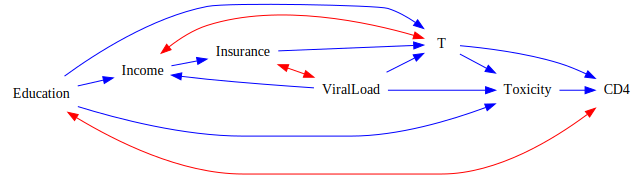

In [2]:
vertices = ['Income', 'Insurance', 'ViralLoad', 'Education', 'T', 'Toxicity', 'CD4']
di_edges = [('ViralLoad', 'Income'), ('ViralLoad', 'T'), ('ViralLoad', 'Toxicity'),
            ('Education', 'Income'), ('Education', 'T'), ('Education', 'Toxicity'),
            ('Income', 'Insurance'), ('Insurance', 'T'), ('T', 'Toxicity'), ('Toxicity', 'CD4'), ('T', 'CD4')]
bi_edges = [('Income', 'T'), ('Insurance', 'ViralLoad'), ('Education', 'CD4')]
G = ADMG(vertices, di_edges, bi_edges)
G.draw(direction="LR")

## Identification of the Causal Effect

Using Ananke, we can ask whether the effect of a given treatment $T$ on a given outcome $Y$ is identified or not. We have implemented the one line ID algorithm provided in [Nested Markov Properties for Acyclic Directed Mixed Graphs](https://arxiv.org/pdf/1701.06686.pdf) which is sound and complete in identifying $p(Y(t))$ or equivalently $p(Y | do(t))$. We show how to use this in Ananke through the following example. 


In [3]:
one_id = OneLineID(graph=G, treatments=['T'], outcomes=['CD4'])
one_id.id()

True

## Estimation of the Causal Effect

Ananke provides an easy interface in order to compute causal effects. First, we instantiate a `CausalEffect` object.

In [4]:
ace_obj = CausalEffect(graph=G, treatment='T', outcome='CD4')  # setting up the CausalEffect object


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
 
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 



In this case, it recommends _Efficient Generalized AIPW_ which is to say, that the estimator used to compute the effect in this case looks a lot like Augmented IPW (which is doubly robust). Further, Ananke uses semiparametric theory in order to provide an estimator that achieves the lowest asymptotic variance.

Given the list of estimators, it is up to the user to specify what estimators they want to work with. For instance, if the user decides to use the efficient generalized AIPW, they only need to use the keyword given in front of it, i.e., `eff-aipw`,  when computing the effect. Let's load up some toy data and use all of the available estimators in order to compute the causal effect.

In [5]:
data = helpers.load_afixable_data() # load some pre-simulated data
ace_ipw = ace_obj.compute_effect(data, "ipw")
ace_gformula = ace_obj.compute_effect(data, "gformula")
ace_aipw = ace_obj.compute_effect(data, "aipw")
ace_eff = ace_obj.compute_effect(data, "eff-aipw")
print("ace using IPW = ", ace_ipw)
print("ace using g-formula = ", ace_gformula)
print("ace using AIPW = ", ace_aipw)
print("ace using efficient AIPW = ", ace_eff)

ace using IPW =  0.4917151858666866
ace using g-formula =  0.49680779965965494
ace using AIPW =  0.5005117929752623
ace using efficient AIPW =  0.49171518586672747


The user can also run bootstraps to obtain the credible intervanls by specifcy the number of bootstraps and the lower and upper quantiles, as shown in the following example. In this case, the call to the `compute_effect` returns three values: the first corresponds to the effect computed on the original data, the second and third are the pre-specified lower and upper quantiles, respectively, (default is set as $0.025$ and $0.975$).

In [6]:
np.random.seed(0)  # setting the seed to get consistent numbers in the documentation
ace, Ql, Qu = ace_obj.compute_effect(data, "eff-aipw", n_bootstraps = 5, Ql=0.025, Qu=0.975)
print(" ace = ", ace, "\n", 
      "lower quantile = ", Ql, "\n", 
      "upper quantile = ", Qu)

 ace =  0.49171518586672747 
 lower quantile =  0.45738153193197784 
 upper quantile =  0.5898403691123406


While Ananke has its own built-in esimation strategy for every identifiable causal effect concerning a single treatment and outcome, users may be interested in building their own estimators based on the identifying functionals/nonparametric influence functions. This allows users to use their own preferred estimation strategies such as sample splitting, using their preferred machine learning model etc. Below, we provide an example for a new causal graph reflecting some background knowledge and we are interested in the causal effect of the treatment $T$ on the outcome $Y.$


 Treatment is p-fixable and graph is mb-shielded. 

 Available estimators are:

1. Primal IPW (p-ipw)
2. Dual IPW (d-ipw)
3. APIPW (apipw)
4. Efficient APIPW (eff-apipw) 
 
Suggested estimator is Efficient APIPW 

beta primal =  I(T=t) x 1/[p(T|C1,C2)p(M2|C1,C2,T,M1)] x Σ_T p(T|C1,C2)p(M2|C1,C2,T,M1) x Y 

beta dual =  [p(M1|C2,T=t)/p(M1|C2,T)] x E[Y|T=t,M1,C2,M2] 

np-IF =  E[βprimal or βdual|C2] - E[βprimal or βdual] + E[βprimal or βdual|C1,C2] - E[βprimal or βdual|C2] + E[βdual|C1,C2,T] - E[βdual|C2,C1] + E[βprimal|C1,T,C2,M1] - E[βprimal|C2,C1,T] + E[βdual|C1,C2,M2,T,M1] - E[βdual|C2,C1,T,M1] + E[βprimal|C1,C2,M2,Y,T,M1] - E[βprimal|C2,C1,T,M1,M2] 

efficient IF = 
 E[βprimal or βdual|C2] - E[βprimal or βdual] + E[βprimal or βdual|C1] - E[βprimal or βdual] + E[βdual|C1,C2,T] - E[βdual|C1,C2] + E[βprimal|T,C2,M1] - E[βprimal|C2,T] + E[βdual|C1,C2,T,M2,M1] - E[βdual|C1,C2,T,M1] + E[βprimal|T,C2,M2,M1,Y] - E[βprimal|T,M1,C2,M2] 



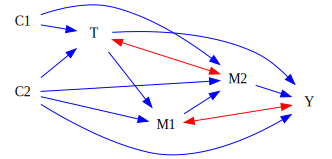

In [7]:
vertices = ['C2', 'C1', 'T', 'M1', 'M2', 'Y']
di_edges = [('C2', 'T'), ('C2', 'M1'), ('C2', 'M2'), ('C2', 'Y'),
            ('C1', 'T'), ('C1', 'M2'),
            ('T', 'M1'), ('M1', 'M2'), ('M2', 'Y'), ('T', 'Y')]
bi_edges = [('T', 'M2'), ('M1', 'Y')]
G = ADMG(vertices, di_edges, bi_edges)
influence = AutomatedIF(G, 'T', 'Y')
print("beta primal = ", influence.beta_primal_, "\n")
print("beta dual = ", influence.beta_dual_, "\n")
print("np-IF = ", influence.nonparametric_if_, "\n")
print("efficient IF = \n", influence.eff_if_, "\n")
G.draw(direction="LR")